Try out the self calibration routines.
May need to: pip install statsmodels

to get the clouds in there

In [11]:
%matplotlib inline
import numpy as np
from lsst.sims.selfcal.generation import genCatalog, offsets, visitOffsets
import lsst.sims.maf.db as db


In [3]:
# generate the visits using OpSim output

# What filter to use
lsstFilter = 'r'
# Read in an Opsim database. Can download from https://www.lsst.org/scientists/simulations/opsim/opsim-v335-benchmark-surveys 
opsimDB = db.OpsimDatabase('minion_1016_sqlite.db')
# Set region to look in
ralim=np.radians(np.array([40,60]) )
declim=np.radians(np.array([-40,-60]))
# How long into the survey
nightMax = 730

# Columns to pull from OpSim
cols = ['ditheredRA', 'ditheredDec', 'rotSkyPos', 'night', 'expMJD','fiveSigmaDepth','obsHistID','transparency' ]

visits = opsimDB.fetchMetricData(cols,'ditheredRA < %f and ditheredRA > %f and ditheredDec > %f and ditheredDec < %f and  filter="%s" and night < %i'%(ralim[1],ralim[0],declim[1],declim[0],lsstFilter,nightMax  ))

# Make dtype names more generic and add any other stuff we want:
visits = visitOffsets(visits, zpOff=1.)


In [5]:
# The different offsets to simulate in the observed stellar magnitudes
offsetList=[]
# Systematic error floor for photometry
offsetList.append(offsets.OffsetSys())
# SNR
offsetList.append(offsets.OffsetSNR())
# Clouds
offsetList.append(offsets.OffsetClouds())

In [7]:
# Generate the catalog of observed stellar magnitudes. Can download the msrgb_1e6.sqlite file from:
# https://lsst-web.ncsa.illinois.edu/sim-data/cal_star_databases/
# That's a subset of stars pulled from the CatSim database. In theory, I have a 25 million star one laying around somehwere too.
nobs, nstars = genCatalog(visits, 'msrgb_1e6.sqlite', offsets=offsetList,lsstFilter=lsstFilter)

# This generates an observations.dat file and starInfo.dat file. 

quering stars with: decl > -71.800000 and decl < -58.200000 and ra < 65.763044 and ra > 34.236956 
got 10765 stars


/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/yoachim/gitRepos/sims_selfcal/python/lsst/sims/selfcal/clouds/Arma/pImage.py:266: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.phasespecI[self.xcen+1:self.nx, self.ycen+1:self.ny] = -1.*numpy.fliplr(numpy.flipud(self.phasespecI[1:self.xcen, 1:self.ycen]))
/Users/yoachim/gitRepos/sims_selfcal/python/lsst/sims/selfcal/clouds/Arma/pImage.py:268: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.phasespecI[1:self.xcen, self.ycen+1:self.ny] = -1.*numpy.fliplr(numpy.flipud(self.phasespecI[self.xcen+1:self.nx, 1:self.ycen]))
/Users/yoachim/gitRepos/sims_selfcal/python/lsst/sims/selfcal/clou

quering stars with: decl > -61.800000 and decl < -48.200000 and ra < 63.809115 and ra > 36.190885 
got 12556 stars
quering stars with: decl > -51.800000 and decl < -38.200000 and ra < 62.910698 and ra > 37.089302 
got 14265 stars


In [8]:
# Now to run the selfcal on the generated catalog
from __future__ import print_function
from builtins import zip
from lsst.sims.selfcal.solver import lsqrSolver
from lsst.sims.selfcal.utils import fastRead
import numpy as np
import matplotlib.pylab as plt
from lsst.sims.selfcal.analysis.healplots import healbin
import healpy as hp


In [9]:
def robustRMS(val):
    iqr = np.percentile(val,75)-np.percentile(val,25)
    return iqr/1.349


In [10]:
mySolver = lsqrSolver(infile='observations.dat', patchOut='solvedPatch.npz', starOut='solvedStar.npz')
mySolver.run()


# Reading file observations.dat
 
LSQR            Least-squares solution of  Ax = b
The matrix A has   561517 rows  and    35608 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =    71216
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.383e+06  2.383e+06    1.0e+00  6.8e-04
     1  3.28728e+00   4.915e+05  4.915e+05    2.1e-01  6.6e-01   1.7e+03  1.0e+00
     2  5.15328e+00   2.865e+05  2.865e+05    1.2e-01  3.8e-01   2.1e+03  2.1e+00
     3  7.25153e+00   1.793e+05  1.793e+05    7.5e-02  3.6e-01   2.5e+03  3.5e+00
     4  8.69597e+00   1.134e+05  1.134e+05    4.8e-02  2.6e-01   2.8e+03  5.0e+00
     5  9.15799e+00   8.356e+04  8.356e+04    3.5e-02  2.2e-01   3.1e+03  6.4e+00
     6  9.23867e+00   6.267e+04  6.267e+04    2.6e-02  1.9e-01   3.3e+03  8.1e+00
     7  9.26191e+00   5.063e+04  5.063e+04    2.1e-02  1.5e-01   3.5e+03  9.8e

In [12]:
# Read in the truth and fits
starsFit = np.load('solvedStar.npz')['result']
trueStars = fastRead('starInfo.dat', dtype=list(zip(['starID','TrueMag', 'ra','dec'],
                                               [int,float,float,float])),
                                               delimiter=',')
trueStars.sort(order='starID')

# Remove any stars that were observed but not fit
mask = np.in1d(trueStars['starID'], starsFit['starID'], assume_unique=True)
trueStars = trueStars[mask]

resid = starsFit['fitMag'] - trueStars['TrueMag']

resid = resid-np.median(resid)


# Reading file starInfo.dat


In [13]:

print('median fitMag - TrueMag = %f'%np.median(resid))
print('std (fitMag - TrueMag) = %f'%np.std(resid))
print('robust RMS = %f'%robustRMS(resid))
rrms = robustRMS(resid)

median fitMag - TrueMag = -0.000000
std (fitMag - TrueMag) = 0.007314
robust RMS = 0.006338


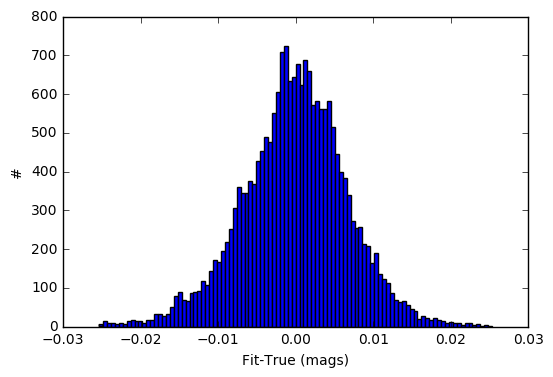

In [14]:
plt.hist(resid, bins=100, range=(-4*rrms,4*rrms))
plt.xlabel('Fit-True (mags)')
plt.ylabel('#')

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


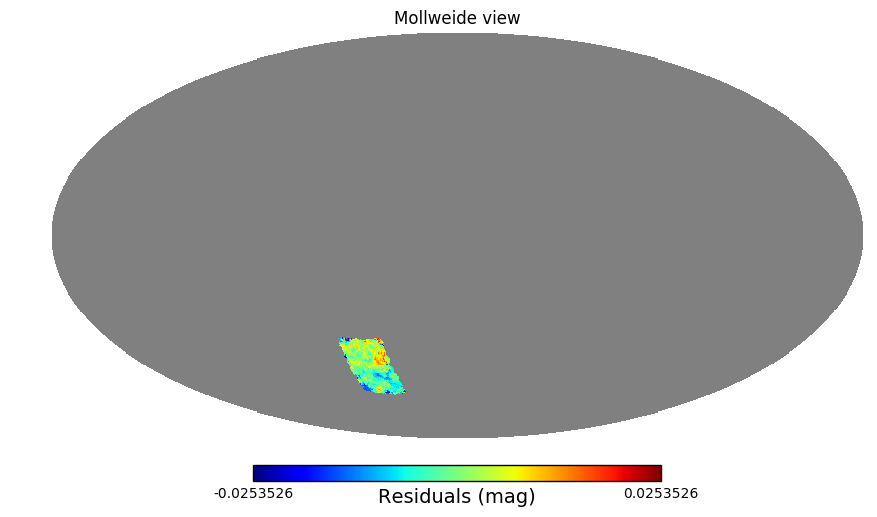

In [15]:
healmap = healbin(np.radians(trueStars['ra']), np.radians(trueStars['dec']), resid)
hp.mollview(healmap, min =-4*rrms, max=4*rrms, unit='Residuals (mag)')